## Import packages and load data

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno 
import matplotlib

from google.colab import files
import io

from google.colab import drive
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

import re
import gensim
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec

import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [13]:
#versions
print('pandas: ' + pd.__version__)
print('numpy: ' + np.__version__)
print('seaborn: ' + sns.__version__)
print('plt: ' + matplotlib.__version__)
print('nltk: ' + nltk.__version__)
print('gensim: ' + gensim.__version__)

pandas: 1.3.5
numpy: 1.21.6
seaborn: 0.11.2
plt: 3.2.2
nltk: 3.7
gensim: 3.6.0


## Load Data

#### GDrive

In [14]:
# #mounting
# drive.mount('/content/gdrive')
# jobs_df = pd.read_csv('gdrive/My Drive/BT4012/fake_job_postings.csv')

#alternative loading
#ul = files.upload()
#jobs_df = pd.read_csv(io.BytesIO(ul['fake_job_postings.csv']))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### Local

In [15]:
jobs_df = pd.read_csv('../datasets/fake_job_postings.csv')

## Jobs DataFrame Overview

#### First look at dataset

In [16]:
jobs_df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [17]:
jobs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

#### Viewing Nulls

In [18]:
percent_missing_normal = jobs_df[jobs_df['fraudulent'] == 0].isnull().sum() * 100 / len(jobs_df[jobs_df['fraudulent'] == 0])
percent_missing_fraud = jobs_df[jobs_df['fraudulent'] == 1].isnull().sum() * 100 / len(jobs_df[jobs_df['fraudulent'] == 1])
missing_value_df = pd.DataFrame({'column_name': jobs_df.columns,
                                 'percent_missing_normal': percent_missing_normal,
                                 'percent_missing_fraud': percent_missing_fraud})
missing_value_df.sort_values('percent_missing_normal', inplace=True, ascending = False)
missing_value_df

,column_name,percent_missing_normal,percent_missing_fraud
salary_range,salary_range,84.453979,74.249423
department,department,64.746679,61.316397
required_education,required_education,44.986482,52.078522
benefits,benefits,40.237452,42.032333
required_experience,required_experience,38.879746,50.230947
function,function,35.958622,38.914550
industry,industry,27.201128,31.755196
employment_type,employment_type,18.984366,27.829099
company_profile,company_profile,15.992712,67.782910
requirements,requirements,14.934760,17.782910


Significantly higher percentage of fraudulent cases do not have values entered for `company_profile`, `salary_range`, `required_experience`.

This could be because fraudulent job postings do not have a legitimate company profile and this would require more effort from fraudsters to create false information. This can be taken into account during feature creation process.

<Figure size 720x576 with 0 Axes>

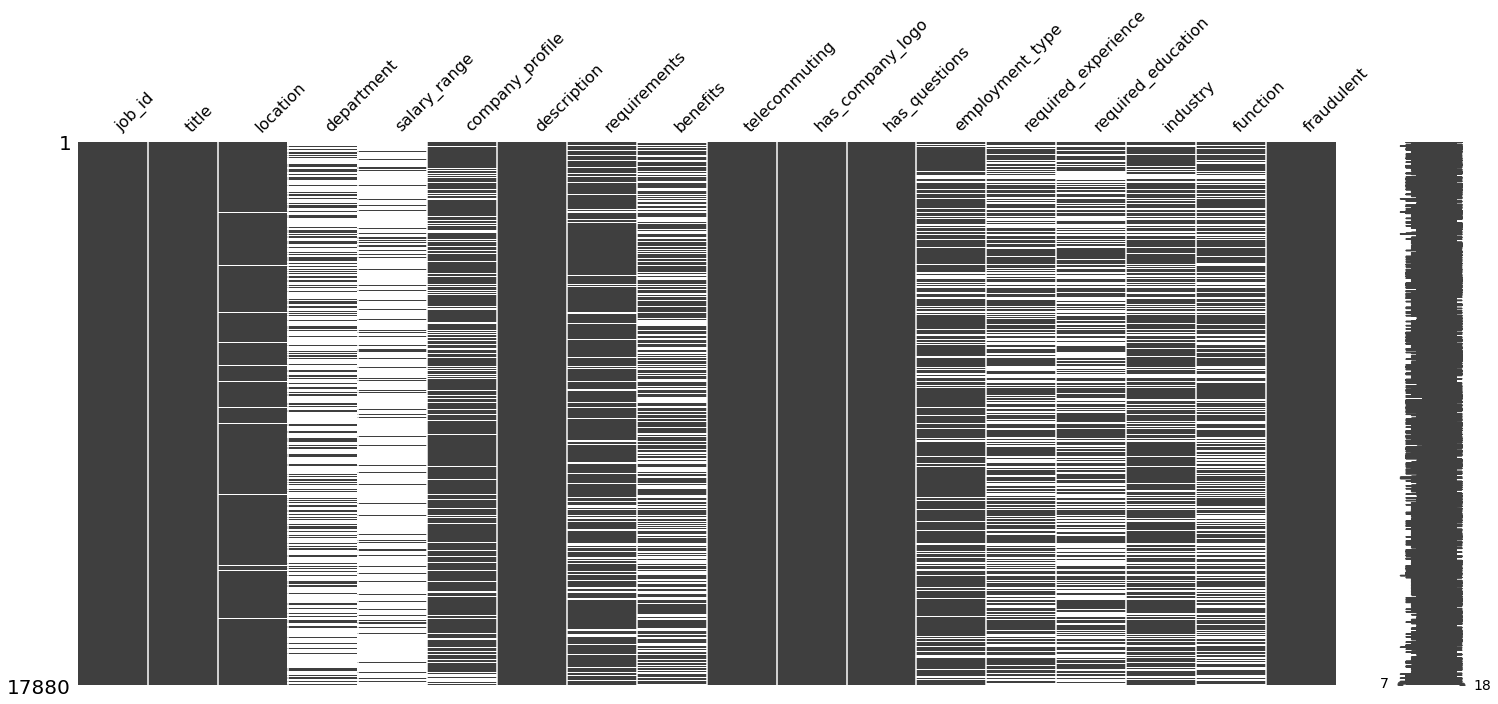

In [19]:
plt.figure(figsize=(10,8))
msno.matrix(jobs_df)
plt.show()

#### Viewing Target Distribution

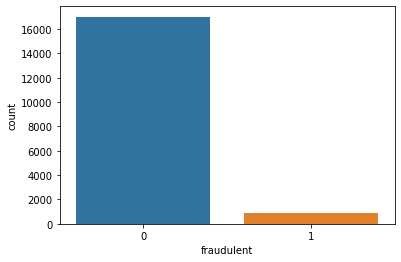

In [20]:
sns.countplot(x="fraudulent", data=jobs_df)
plt.show()  
#highly imbalance dataset where there are only small numbers of fraudulent instances

#### Viewing Unique Value Counts for each variable

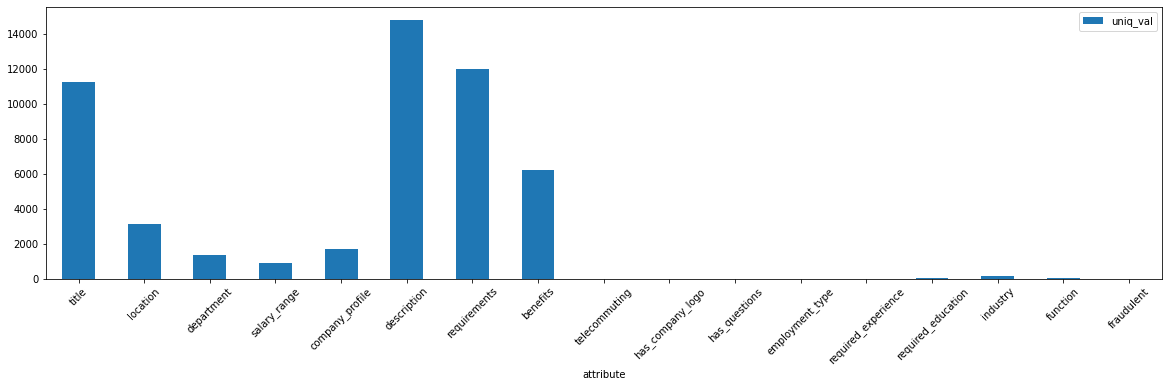

In [21]:
# number of unique values for each variable
df_uniq = pd.DataFrame(list(jobs_df.columns)[1:]).rename(columns={0:"attribute"})
df_uniq['uniq_val'] = [jobs_df[attribute].nunique() for attribute in jobs_df.columns[1:]]
df_uniq.plot(x='attribute', y='uniq_val', figsize=(20, 5), kind='bar', rot=45)

In [22]:
df_uniq

,attribute,uniq_val
0,title,11231
1,location,3105
2,department,1337
3,salary_range,874
4,company_profile,1709
5,description,14801
6,requirements,11968
7,benefits,6205
8,telecommuting,2
9,has_company_logo,2


## Cleaning Data



#### Cleaning Data Types

In [23]:
jobs_df['job_id'] = jobs_df[jobs_df['job_id'].notna()]['job_id'].astype('str')
jobs_df['salary_range'] = jobs_df[jobs_df['salary_range'].notna()]['salary_range'].astype('str') #classify as string as there are 875 unique values, too many categories
jobs_df['telecommuting'] = jobs_df[jobs_df['telecommuting'].notna()]['telecommuting'].astype('boolean')
jobs_df['has_company_logo'] = jobs_df[jobs_df['has_company_logo'].notna()]['has_company_logo'].astype('boolean')
jobs_df['has_questions'] = jobs_df[jobs_df['has_questions'].notna()]['has_questions'].astype('boolean')
jobs_df['employment_type'] = jobs_df[jobs_df['employment_type'].notna()]['employment_type'].astype('category')
jobs_df['location'] = jobs_df[jobs_df['location'].notna()]['location'].astype('category')
jobs_df['required_education'] = jobs_df[jobs_df['required_education'].notna()]['required_education'].astype('category')
jobs_df['required_experience'] = jobs_df[jobs_df['required_experience'].notna()]['required_experience'].astype('category')
jobs_df['function'] = jobs_df[jobs_df['function'].notna()]['function'].astype('category') 
jobs_df['fraudulent'] = jobs_df[jobs_df['fraudulent'].notna()]['fraudulent'].astype('category')
jobs_df['industry'] = jobs_df[jobs_df['industry'].notna()]['industry'].astype('str') #132 cats, too many categories
jobs_df['company_profile'] = jobs_df[jobs_df['company_profile'].notna()]['company_profile'].astype('str')
jobs_df['benefits'] = jobs_df[jobs_df['benefits'].notna()]['benefits'].astype('str')
jobs_df['description'] = jobs_df[jobs_df['description'].notna()]['description'].astype('str')
jobs_df['requirements'] = jobs_df[jobs_df['requirements'].notna()]['requirements'].astype('str')

#### Categorising Presence of Salary

In [24]:
jobs_df['salary_indicated'] = jobs_df['salary_range'].apply(lambda x: 1 if x is not np.nan else 0)

In [25]:
jobs_df = jobs_df.drop(['salary_range'], axis = 1)

#### Cleaning Location

- standardise to country code

In [26]:
#convert location to cat
jobs_df['location']= jobs_df['location'].str[:2]

#### Cleaning Industry

In [27]:
# Filling in nulls by imputing industry based on company_profile
list_of_available_industries = jobs_df['industry'].unique()
list_of_available_industries = [x for x in list_of_available_industries if pd.notnull(x)]
new_industry_list = []

for _,row in jobs_df.iterrows():
  if str(row['industry']) != 'nan':
    new_industry_list.append(row['industry'])
  else:
    broke = False
    for industry in list_of_available_industries:
      if str(row['company_profile']) != 'nan':
        if industry.lower() in row['company_profile'].lower():
          new_industry_list.append(industry)
          broke = True
          break
    if broke == False:
      new_industry_list.append(row['industry'])

In [28]:
jobs_df['industry'] = new_industry_list # Cleaned industry nulls reduced from 4903 to 3604

#### Reducing Cardinality

In [29]:
#Education
jobs_df['required_education'] = jobs_df['required_education'].replace({'Vocational': 'Vocational',
                                                                       'Vocational - Degree': 'Vocational', 
                                                                       'Vocational - HS Diploma': 'Vocational',
                                                                        'Some High School Coursework': 'Normal education',
                                                                        'Some College Coursework Completed': 'Normal education',
                                                                        'High School or equivalent' : 'Normal education',
                                                                        'Associate Degree': 'Higher Education',
                                                                        "Bachelor's Degree": 'Higher Education', 
                                                                        "Master's Degree" : 'Highest Education', 
                                                                        'Professional': 'Highest Education', 
                                                                         'Doctorate' : 'Highest Education'
                                                                        })

In [30]:
#Industry
jobs_df['industry'] = jobs_df['industry'].replace({'Public Policy' : 'Government and Legislation',
                                                  'Sports' : 'Entertainment',
                                                  'Motion Pictures and Film' : 'Entertainment',
                                                  'Transportation/Trucking/Railroad' : 'Transportation',
                                                  'Maritime' : 'Transportation',
                                                  'Warehousing' : 'Manufacturing',
                                                  'Cosmetics' : 'Fashion',
                                                  'Medical Devices' : 'Healthcare',
                                                  'Computer Networking' : 'Computer and Technology',
                                                  'Commercial Real Estate' : 'Construction',
                                                  'Information Services' : 'Computer and Technology',
                                                  'Online Media' : 'Media and News',
                                                  'Individual & Family Services' : 'Non-Profit Organisation',
                                                  'Utilities' : 'Energy',
                                                  'Plastics' : 'Manufacturing',
                                                  'Farming' : 'Agriculture',
                                                  'Research' : 'Education',
                                                  'Biotechnology' : 'Computer and Technology',
                                                  'Logistics and Supply Chain' : 'Manufacturing',
                                                  'Graphic Design' : 'Advertising and marketing',
                                                  'Airlines/Aviation' : 'Aerospace',
                                                  'Computer Games' : 'Computer and Technology',
                                                  'Real Estate' : 'Construction',
                                                  'Human Resources' : 'HR and Consulting',
                                                  'Public Safety' : 'Government and Legislation',
                                                  'Retail' : 'Fashion',
                                                  'Animation' : 'Entertainment',
                                                  'Shipbuilding' : 'Construction',
                                                  'Fishery' : 'Agriculture',
                                                  'Outsourcing/Offshoring' : 'Manufacturing',
                                                  'Medical Practice' : 'Healthcare',
                                                  'Hospital & Health Care' : 'Healthcare',
                                                  'Apparel & Fashion' : 'Fashion',
                                                  'Military' : 'Government and Legislation',
                                                  'Education Management' : 'Education',
                                                  'Performing Arts' : 'Entertainment',
                                                  'Computer Hardware' : 'Computer and Technology',
                                                  'Industrial Automation' : 'Computer and Technology',
                                                  'Civil Engineering' : 'Construction',
                                                  'Government Administration' : 'Government and Legislation',
                                                  'Hospitality' : 'Hospitality',
                                                  'Broadcast Media' : 'Media and News',
                                                  'Telecommunications' : 'Telecommunication',
                                                  'Professional Training & Coaching' : 'Education',
                                                  'Luxury Goods & Jewelry' : 'Fashion',
                                                  'Security and Investigations' : 'Government and Legislation',
                                                  'Computer & Network Security' : 'Computer and Technology',
                                                  'Packaging and Containers' : 'Manufacturing',
                                                  'Entertainment' : 'Entertainment',
                                                  'Civic & Social Organization' : 'Non-Profit Organisation',
                                                  'Business Supplies and Equipment' : 'Manufacturing',
                                                  'Mental Health Care' : 'Healthcare',
                                                  'Import and Export' : 'Manufacturing',
                                                  'Legal Services' : 'Government and Legislation',
                                                  'Oil & Energy' : 'Energy',
                                                  'Fund-Raising' : 'Non-Profit Organisation',
                                                  'Computer Software' : 'Computer and Technology',
                                                  'Leisure, Travel & Tourism' : 'Hospitality',
                                                  'Information Technology and Services' : 'Computer and Technology',
                                                  'Banking' : 'Finance and Economic',
                                                  'Mechanical or Industrial Engineering' : 'Manufacturing',
                                                  'Executive Office' : 'HR and Consulting',
                                                  'Furniture' : 'Manufacturing',
                                                  'Sporting Goods' : 'Fashion',
                                                  'Translation and Localization' : 'Media and News',
                                                  'Media Production' : 'Media and News',
                                                  'Capital Markets' : 'Finance and Economic',
                                                  'Food & Beverages' : 'Food and Beverage',
                                                  'Internet' : 'Computer and Technology',
                                                  'Primary/Secondary Education' : 'Education',
                                                  'Photography' : 'Entertainment',
                                                  'Gambling & Casinos' : 'Entertainment',
                                                  'Consumer Goods' : 'Manufacturing',
                                                  'Design' : 'Fashion',
                                                  'Electrical/Electronic Manufacturing' : 'Manufacturing',
                                                  'Wholesale' : 'Manufacturing',
                                                  'Venture Capital & Private Equity' : 'Finance and Economic',
                                                  'Financial Services' : 'Finance and Economic',
                                                  'Music' : 'Entertainment',
                                                  'Events Services' : 'Entertainment',
                                                  'Mining & Metals' : 'Manufacturing',
                                                  'Machinery' : 'Manufacturing',
                                                  'Package/Freight Delivery' : 'Transportation',
                                                  'Architecture & Planning' : 'Construction',
                                                  'Nanotechnology' : 'Computer and Technology',
                                                  'Consumer Services' : 'Hospitality',
                                                  'Program Development' : 'HR and Consulting',
                                                  'Management Consulting' : 'HR and Consulting',
                                                  'Consumer Electronics' : 'Entertainment',
                                                  'Publishing' : 'Media and News',
                                                  'Building Materials' : 'Construction',
                                                  'Chemicals' : 'Manufacturing',
                                                  'Law Practice' : 'Government and Legislation',
                                                  'Construction' : 'Construction',
                                                  'Philanthropy' : 'Non-Profit Organisation',
                                                  'Accounting' : 'Finance and Economic',
                                                  'Investment Management' : 'Finance and Economic',
                                                  'Environmental Services' : 'Energy',
                                                  'Investment Banking' : 'Finance and Economic',
                                                  'Automotive' : 'Transportation',
                                                  'Renewables & Environment' : 'Energy',
                                                  'Wireless' : 'Computer and Technology',
                                                  'Writing and Editing' : 'Media and News',
                                                  'Government Relations' : 'Government and Legislation',
                                                  'Libraries' : 'Education',
                                                  'Textiles' : 'Manufacturing',
                                                  'Higher Education' : 'Education',
                                                  'Ranching' : 'Agriculture',
                                                  'Nonprofit Organization Management' : 'Non-Profit Organisation',
                                                  'Semiconductors' : 'Manufacturing',
                                                  'Facilities Services' : 'Entertainment',
                                                  'Religious Institutions' : 'Non-Profit Organisation',
                                                  'Pharmaceuticals' : 'Healthcare',
                                                  'Insurance' : 'Healthcare',
                                                  'International Trade and Development' : 'Finance and Economic',
                                                  'Printing' : 'Manufacturing',
                                                  'Health, Wellness and Fitness' : 'Healthcare',
                                                  'Wine and Spirits' : 'Food and Beverage',
                                                  'Restaurants' : 'Food and Beverage',
                                                  'Market Research' : 'HR and Consulting',
                                                  'Aviation & Aerospace' : 'Aerospace',
                                                  'Defense & Space' : 'Aerospace',
                                                  'Veterinary' : 'Healthcare',
                                                  'Marketing and Advertising' : 'Advertising and marketing',
                                                  'E-Learning' : 'Education',
                                                  'Law Enforcement' : 'Government and Legislation',
                                                  'Staffing and Recruiting' : 'Hospitality',
                                                  'Public Relations and Communications' : 'Media and News',
                                                  'Food Production' : 'Food and Beverage',
                                                  'Museums and Institutions' : 'Education',
                                                  'Alternative Dispute Resolution' : 'Hospitality'})

#### Cleaning text: Concatenate and lemmatise relevant text

In [31]:
jobs_df.shape

(17880, 18)

In [32]:
jobs_df['concat_text'] = jobs_df[["company_profile", "description", "requirements", "benefits"]].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)

In [33]:
jobs_df['concat_text'] = jobs_df['concat_text'].str.strip().replace("", np.nan)

In [34]:
jobs_df = jobs_df.dropna(subset = ['concat_text'])

In [35]:
jobs_df.shape

(17879, 19)

In [36]:
def remove_link_punc(string):
    temp_string = re.sub('http[s]?://[^ ]+', ' ', string)
    temp_string = re.sub("\S*\d\S*", " ", temp_string)
    temp_string = re.sub("&[^\s]+", " ", temp_string)
    regex = re.compile('[^a-zA-Z]')
    temp_string = regex.sub(' ', temp_string)
    temp_string = re.sub(r"([a-z])([A-Z])", r"\1 \2", temp_string)
    clean_string = re.sub('\s+', ' ', temp_string).lower()
    return clean_string.strip()

In [37]:
jobs_df['clean_text'] = jobs_df['concat_text'].apply(remove_link_punc)

In [38]:
def tokenize_lemmatize(string):
    lemmatizer = WordNetLemmatizer()
    word_list = word_tokenize(string)
    return [lemmatizer.lemmatize(w) for w in word_list]

In [39]:
jobs_df['lst_tokens'] = jobs_df['clean_text'].apply(tokenize_lemmatize)

In [40]:
jobs_df = jobs_df.drop(['clean_text'], axis = 1)

#### Cleaning text: Remove non - english text

- There could be presence of other languages in textual data. Some job postings have both english and foreign language in their textual data. However, it does not appear for seen fraud cases. 

- Since this is not a useful distinguishing feature of non-fraud, we filter non-english postings out

In [41]:
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 981 kB 15.3 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993241 sha256=f04daeac00d8e8cd1b8f5bab262d31d3255d0c6f8d359a00072525e382122011
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [42]:
import langdetect

# explore languages for fraudulent company profile first
text_df = pd.DataFrame()

#we analyse language detected in company profile as it has the least null values
copy_df = jobs_df.copy().dropna(subset = ['company_profile'])
txt = copy_df.loc[:,'company_profile']
copy_df['lang'] = txt.apply(lambda x: langdetect.detect(x) if x.strip() != "" else "")

In [43]:
# EDA for language
copy_df.groupby(['fraudulent','lang'])['lang'].agg(['count']).sort_values(by='fraudulent', ascending = False)

count
fraudulent lang       
1          ca        0
           de        0
           ru        0
           pt        0
           pl        0
           no        0
           nl        0
           it        0
           fr        0
           es        0
           en      279
           el        0
           sv        0
0          de       10
           sv        1
           ru        9
           pt        2
           pl        1
           no        1
           nl       26
           it        1
           fr       17
           es       24
           en    14117
           el       40
           ca       44

In [44]:
jobs_df = copy_df[copy_df['lang'].str.contains('en')]

In [45]:
jobs_df.shape

(14396, 21)

In [46]:
jobs_df = jobs_df.drop(['lang'], axis = 1)

## Remove uneeeded columns

In [49]:
jobs_df = jobs_df.drop(['title','department'], axis = 1)

## Feature Engineering

In [50]:
jobs_df['num_words_company_profile'] = jobs_df['company_profile'].str.split().map(lambda x: len(x) if type(x) != float else 0)

## Train test split

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [52]:
cols_remove = ['fraudulent']
X_cols = [i for i in list(jobs_df.columns) if i not in cols_remove]

In [53]:
# Train test split
X = jobs_df[X_cols]
y = jobs_df['fraudulent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2022, shuffle = True , stratify = y) # 80-20 split

In [54]:
X_train = X_train.reset_index(drop = True)

In [55]:
X_test = X_test.reset_index(drop = True)

## Correlation Analysis

In [56]:
# For entropy computation
!pip install pyitlib
from pyitlib import discrete_random_variable as drv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [57]:
X_train_correlation = X_train[['location','telecommuting','has_company_logo','has_questions','employment_type','required_experience','required_education','industry','function','salary_indicated']]

In [58]:
X_train_correlation['telecommuting'] = X_train_correlation['telecommuting'].apply(lambda x: 'True' if x==True else 'False' if x==False else np.nan )
X_train_correlation['has_questions'] = X_train_correlation['has_questions'].apply(lambda x: 'True' if x==True else 'False' if x == False else np.nan )
X_train_correlation['has_company_logo'] = X_train_correlation['has_company_logo'].apply(lambda x: 'True' if x==True else 'False' if x == False else np.nan)
X_train_correlation['salary_indicated'] = X_train_correlation['salary_indicated'].apply(lambda x: 'True' if x==1 else 'False' if x == False else np.nan)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [59]:
# Compute Entropy
cat_variables = list(X_train_correlation.columns)
entropies = pd.DataFrame([(x, drv.entropy(X_train_correlation[x])) for x in cat_variables], columns=['cat1', 'H(cat1)'])

# Compute Conditional Entropy
results = []
for cat1 in cat_variables:
    for cat2 in cat_variables:
        if cat1!=cat2:
            results.append((cat1, cat2, drv.entropy_conditional(X_train_correlation[cat1], X_train_correlation[cat2])))

conditional_entropy = pd.DataFrame(results, columns=['cat1', 'cat2', 'H(cat1|cat2)'])

information_gain = entropies.merge(conditional_entropy)
information_gain['information gain'] = information_gain['H(cat1)'] - information_gain['H(cat1|cat2)']

information_gain.head()

,cat1,H(cat1),cat2,H(cat1|cat2),information gain
0,location,2.4651753741567783,telecommuting,2.455582416387784,0.009593
1,location,2.4651753741567783,has_company_logo,2.4423538453761884,0.022822
2,location,2.4651753741567783,has_questions,2.429729409630317,0.035446
3,location,2.4651753741567783,employment_type,2.343554195305041,0.121621
4,location,2.4651753741567783,required_experience,2.374131015457823,0.091044


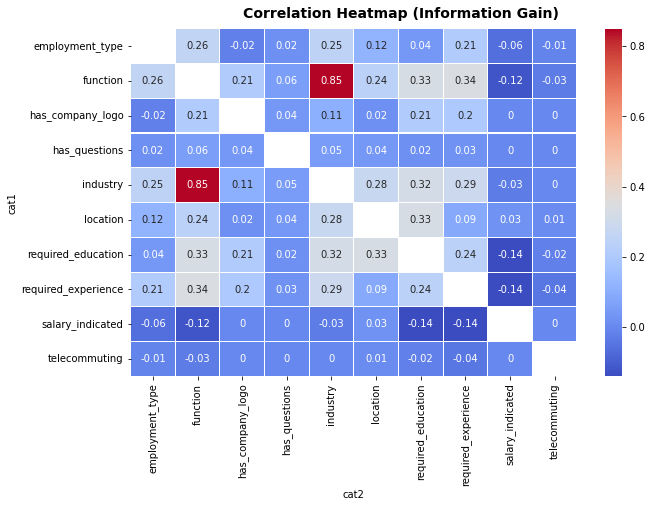

In [60]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

hm = sns.heatmap(round(information_gain.pivot_table(index='cat1', columns='cat2', values='information gain', aggfunc=np.sum),2), 
                 ax=ax,           # Axes in which to draw the plot, otherwise use the currently-active Axes.
                 cmap="coolwarm", # Color Map.
                 #square=True,    # If True, set the Axes aspect to “equal” so each cell will be square-shaped.
                 annot=True, 
                 #annot_kws={"size": 14},
                 linewidths=.05)

fig.subplots_adjust(top=0.93)

t = fig.suptitle('Correlation Heatmap (Information Gain)', fontsize=14, fontweight='bold')

## Categorical Variable Analysis

#### Splitting data into Fraud and non-fraud

In [61]:
train_data = X_train.copy()
train_data = train_data.merge(y_train, left_index=True, right_index=True)
train_data.head()

,job_id,location,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,salary_indicated,concat_text,lst_tokens,num_words_company_profile,fraudulent
0,17871,US,PROSULTING IS PEOPLE The ProSulting difference...,We are activity searching for a Senior Financi...,Must have a minimum of 3 + years in Financial ...,NaN,False,True,True,Full-time,Mid-Senior level,Higher Education,Fashion,Financial Analyst,0,PROSULTING IS PEOPLE The ProSulting difference...,"[prosulting, is, people, the, pro, sulting, di...",220,0
1,1981,US,Valor Services provides Workforce Solutions th...,About the CompanyThis is an amazing job opport...,"Education: Bachelor’s degree in Geology, Geoph...","Industry, Location and CompensationIndustry: E...",False,True,False,Full-time,Associate,Higher Education,Energy,NaN,0,Valor Services provides Workforce Solutions th...,"[valor, service, provides, workforce, solution...",141,0
2,15465,US,Back to #URL_e25642d9604fc2ff4afed5946b4110821...,"This is a worldwide, global placement.HeroX is...","Manage multiple projects at once, keeping impe...",HeroX is a young startup. We offer a generous ...,True,True,False,Full-time,NaN,Unspecified,Computer and Technology,Project Management,0,Back to #URL_e25642d9604fc2ff4afed5946b4110821...,"[back, to, is, a, new, startup, incubated, and...",152,0
3,7494,US,SpotSource Solutions LLC is a Global Human Cap...,Title: Sales Support Type: Permanent – Full-T...,"Reporting:Sales Force Pipeline, Sharepoint Co-...",Benefits Offered,False,True,True,Full-time,Entry level,Unspecified,Entertainment,Sales,1,SpotSource Solutions LLC is a Global Human Cap...,"[spot, source, solution, llc, is, a, global, h...",207,0
4,16720,GB,We're Hiring!Yoyo is bringing together a game-...,Yoyo is hiring an experienced Software Develop...,you have experience building scalable Android ...,being apart of an early-stage venture-backed s...,False,True,True,Full-time,Mid-Senior level,NaN,Finance and Economic,Engineering,0,We're Hiring!Yoyo is bringing together a game-...,"[we, re, hiring, yoyo, is, bringing, together,...",130,0


In [62]:
fraud_data = train_data[train_data['fraudulent'] == 1]
no_fraud = train_data[train_data['fraudulent'] == 0]

#### Company Logo

In [63]:
fc = fraud_data.groupby(['has_company_logo', 'fraudulent']).count()['job_id'].reset_index()
fc['proportion'] = fc['job_id'].apply(lambda x: x/fc['job_id'].sum() * 100)

In [64]:
no_fc = no_fraud.groupby(['has_company_logo', 'fraudulent']).count()['job_id'].reset_index()
no_fc['proportion'] = no_fc['job_id'].apply(lambda x: x/no_fc['job_id'].sum() * 100)

In [65]:
total_fc = pd.concat([fc, no_fc], axis=0)
print(total_fc)
total_fc = total_fc[total_fc['proportion'] > 0] 
total_fc

   has_company_logo fraudulent  job_id  proportion
0             False          0       0    0.000000
1             False          1      13    8.496732
2              True          0       0    0.000000
3              True          1     140   91.503268
0             False          0     517    7.142857
1             False          1       0    0.000000
2              True          0    6721   92.857143
3              True          1       0    0.000000


,has_company_logo,fraudulent,job_id,proportion
1,False,1,13,8.496732
3,True,1,140,91.503268
0,False,0,517,7.142857
2,True,0,6721,92.857143


#### Questions

In [66]:
qn = fraud_data.groupby(['has_questions', 'fraudulent']).count()['job_id'].reset_index()
qn['proportion'] = qn['job_id'].apply(lambda x: x/qn['job_id'].sum() * 100)

In [67]:
no_qn = no_fraud.groupby(['has_questions', 'fraudulent']).count()['job_id'].reset_index()
no_qn['proportion'] = no_qn['job_id'].apply(lambda x: x/no_qn['job_id'].sum() * 100)

In [68]:
total_qn = pd.concat([qn, no_qn], axis=0)
total_qn = total_qn[total_qn['proportion'] > 0]
total_qn

,has_questions,fraudulent,job_id,proportion
1,False,1,74,48.366013
3,True,1,79,51.633987
0,False,0,3397,46.932854
2,True,0,3841,53.067146


#### Telecommuting

In [69]:
tele = fraud_data.groupby(['telecommuting', 'fraudulent']).count()['job_id'].reset_index()
tele['proportion'] = tele['job_id'].apply(lambda x: x/tele['job_id'].sum() * 100)

In [70]:
no_tele = no_fraud.groupby(['telecommuting', 'fraudulent']).count()['job_id'].reset_index()
no_tele['proportion'] = no_tele['job_id'].apply(lambda x: x/no_qn['job_id'].sum() * 100)

In [71]:
total_tele = pd.concat([tele, no_tele])
total_tele = total_tele[total_tele['proportion'] > 0]
total_tele

,telecommuting,fraudulent,job_id,proportion
1,False,1,149,97.385621
3,True,1,4,2.614379
0,False,0,6984,96.490743
2,True,0,254,3.509257


#### Employment Type

In [72]:
et = fraud_data.groupby(['employment_type', 'fraudulent']).count()['job_id'].reset_index()
et['proportion'] = et['job_id'].apply(lambda x: x/et['job_id'].sum() * 100)

In [73]:
no_et = no_fraud.groupby(['employment_type', 'fraudulent']).count()['job_id'].reset_index()
no_et['proportion'] = no_et['job_id'].apply(lambda x: x/no_et['job_id'].sum() * 100)

In [74]:
total_et = pd.concat([et, no_et])
total_et = total_et[total_et['proportion'] > 0]
total_et

,employment_type,fraudulent,job_id,proportion
1,Contract,1,14,10.687023
3,Full-time,1,102,77.862595
5,Other,1,2,1.526718
7,Part-time,1,10,7.633588
9,Temporary,1,3,2.290076
0,Contract,0,635,10.641864
2,Full-time,0,4847,81.230099
4,Other,0,85,1.424501
6,Part-time,0,307,5.144964
8,Temporary,0,93,1.558572


#### Required Education

In [75]:
re = fraud_data.groupby(['required_education', 'fraudulent']).count()['job_id'].reset_index()
re['proportion'] = re['job_id'].apply(lambda x: x/re['job_id'].sum() * 100)

In [76]:
no_re = no_fraud.groupby(['required_education', 'fraudulent']).count()['job_id'].reset_index()
no_re['proportion'] = no_re['job_id'].apply(lambda x: x/no_re['job_id'].sum() * 100)

In [77]:
total_re = pd.concat([re, no_re])
total_re = total_re[total_re['proportion'] > 0]
total_re

,required_education,fraudulent,job_id,proportion
1,Certification,1,3,3.333333
3,Higher Education,1,53,58.888889
5,Highest Education,1,2,2.222222
7,Normal education,1,18,20.000000
9,Unspecified,1,14,15.555556
0,Certification,0,75,1.835536
2,Higher Education,0,2285,55.922663
4,Highest Education,0,197,4.821341
6,Normal education,0,981,24.008811
8,Unspecified,0,522,12.775330


#### Required Experience

In [78]:
rexp = fraud_data.groupby(['required_experience', 'fraudulent']).count()['job_id'].reset_index()
rexp['proportion'] = rexp['job_id'].apply(lambda x: x/rexp['job_id'].sum() * 100)

In [79]:
no_rexp = no_fraud.groupby(['required_experience', 'fraudulent']).count()['job_id'].reset_index()
no_rexp['proportion'] = no_rexp['job_id'].apply(lambda x: x/no_rexp['job_id'].sum() * 100)

In [80]:
total_rexp = pd.concat([rexp, no_rexp])
total_rexp = total_rexp[total_rexp['proportion'] > 0]
total_rexp

,required_experience,fraudulent,job_id,proportion
1,Associate,1,20,21.052632
3,Director,1,3,3.157895
5,Entry level,1,22,23.157895
9,Internship,1,7,7.368421
11,Mid-Senior level,1,32,33.684211
13,Not Applicable,1,11,11.578947
0,Associate,0,928,20.760626
2,Director,0,189,4.228188
4,Entry level,0,1182,26.442953
6,Executive,0,61,1.364653


#### Combining and plotting results

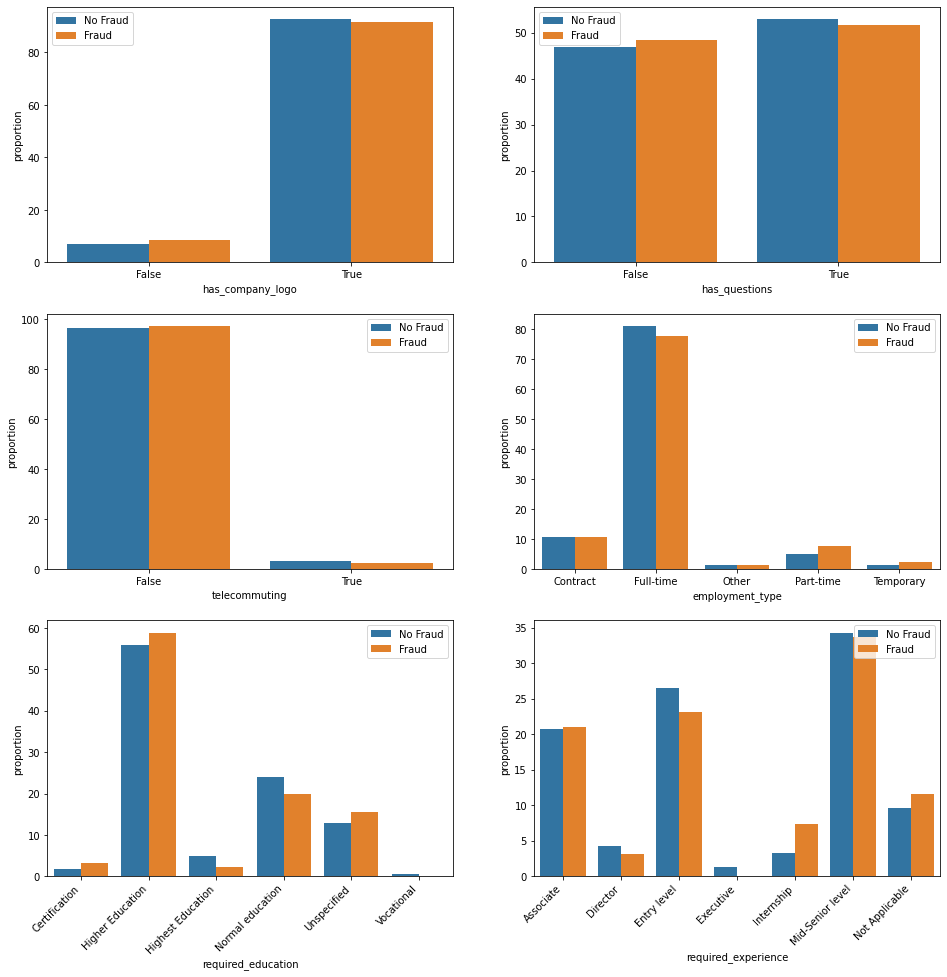

In [81]:
f, axes = plt.subplots(3, 2, figsize=(16, 16), sharex=False)
ax = plt.gca()

labels = ['No Fraud', 'Fraud']

plt1 = sns.barplot(x="has_company_logo", y='proportion', hue="fraudulent", data=total_fc, ax=axes[0][0])
h, _ = plt1.get_legend_handles_labels()
plt1.legend(h, labels)

plt2 = sns.barplot(x="has_questions", y='proportion', hue="fraudulent", data=total_qn, ax=axes[0][1])
h, _ = plt2.get_legend_handles_labels()
plt2.legend(h, labels)

plt3 = sns.barplot(x="telecommuting", y='proportion', hue="fraudulent", data=total_tele, ax=axes[1][0])
h, _ = plt3.get_legend_handles_labels()
plt3.legend(h, labels)

plt4 = sns.barplot(x='employment_type', y='proportion', hue='fraudulent', data=total_et, ax=axes[1][1])
h, _ = plt4.get_legend_handles_labels()
plt4.legend(h, labels)

plt5 = sns.barplot(x='required_education', y='proportion', hue='fraudulent', data=total_re, ax=axes[2][0])
plt5.set_xticklabels(plt5.get_xticklabels(), rotation=45, ha='right')
h, _ = plt5.get_legend_handles_labels()
plt5.legend(h, labels, loc='upper right')

plt6 = sns.barplot(x='required_experience', y='proportion', hue='fraudulent', data=total_rexp, ax=axes[2][1])
plt6.set_xticklabels(plt6.get_xticklabels(), rotation=45, ha='right')
h, _ = plt6.get_legend_handles_labels()
plt6.legend(h, labels, loc='upper right')

## Word Count Analysis

#### Combined Word Analysis

In [82]:
word_data = X_train.copy()
word_data = word_data.merge(y_train, left_index=True, right_index=True)

In [83]:
# text_columns = ['company_profile', 'description', 'requirements', 'benefits']
# word_data['combined_text'] = word_data[text_columns].apply(lambda x: ','.join(x.dropna().astype(str)), axis=1)

In [84]:
word_data = word_data[word_data['concat_text'].notna()]

In [85]:
word_data['num_words_combined_text'] = word_data['concat_text'].str.split().map(lambda x: len(x) if type(x) != float else 0)

##### Plotting

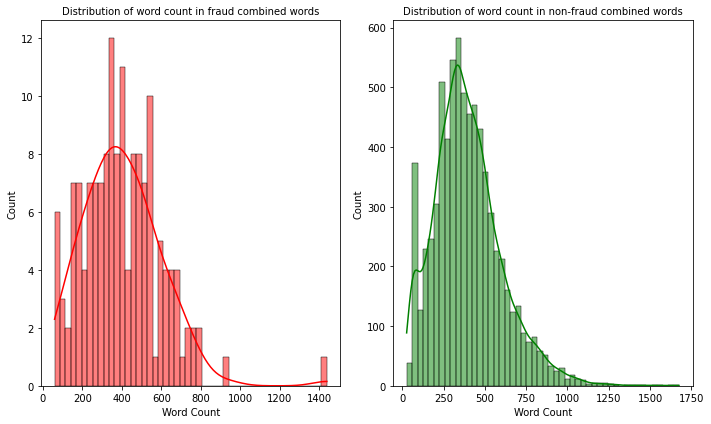

In [86]:
f, axes = plt.subplots(1, 2, figsize=(10, 6), sharex=False)
num_words_fraud = word_data[word_data["fraudulent"]==1]['num_words_combined_text']
num_words_nonfraud = word_data[word_data["fraudulent"]==0]['num_words_combined_text']
sns.histplot(num_words_fraud, 
             color='r', bins=50, kde=True, ax=axes[0])
sns.histplot(num_words_nonfraud, 
             color='g', bins=50, kde=True, ax=axes[1])

axes[0].set_title('Distribution of word count in fraud combined words', fontsize=10)
axes[1].set_title('Distribution of word count in non-fraud combined words', fontsize=10)
axes[0].set(xlabel="Word Count", ylabel = "Count")
axes[1].set(xlabel="Word Count", ylabel = "Count")
plt.tight_layout()
plt.show()

#### Company Profile

In [87]:
word_data['num_words_company_profile'] = word_data['company_profile'].str.split().map(lambda x: len(x) if type(x) != float else 0)

##### Plotting

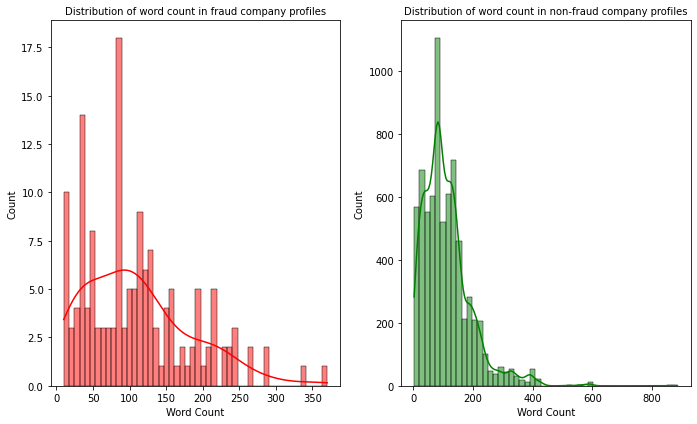

In [88]:
f, axes = plt.subplots(1, 2, figsize=(10, 6), sharex=False)
num_words_fraud = word_data[word_data["fraudulent"]==1]['num_words_company_profile']
num_words_nonfraud = word_data[word_data["fraudulent"]==0]['num_words_company_profile']
sns.histplot(num_words_fraud, 
             color='r', bins=50, kde=True, ax=axes[0])
sns.histplot(num_words_nonfraud, 
             color='g', bins=50, kde=True, ax=axes[1])

axes[0].set_title('Distribution of word count in fraud company profiles', fontsize=10)
axes[1].set_title('Distribution of word count in non-fraud company profiles', fontsize=10)
axes[0].set(xlabel="Word Count", ylabel = "Count")
axes[1].set(xlabel="Word Count", ylabel = "Count")
plt.tight_layout()
plt.show()

#### Description

In [89]:
word_data['num_words_description'] = word_data['description'].str.split().map(lambda x: len(x) if type(x) != float else 0)

##### Plotting

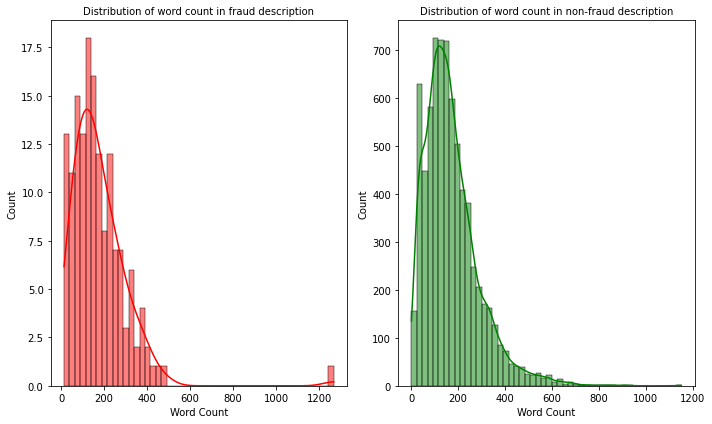

In [90]:
f, axes = plt.subplots(1, 2, figsize=(10, 6), sharex=False)
num_words_fraud = word_data[word_data["fraudulent"]==1]['num_words_description']
num_words_nonfraud = word_data[word_data["fraudulent"]==0]['num_words_description']
sns.histplot(num_words_fraud, 
             color='r', bins=50, kde=True, ax=axes[0])
sns.histplot(num_words_nonfraud, 
             color='g', bins=50, kde=True, ax=axes[1])

axes[0].set_title('Distribution of word count in fraud description', fontsize=10)
axes[1].set_title('Distribution of word count in non-fraud description', fontsize=10)
axes[0].set(xlabel="Word Count", ylabel = "Count")
axes[1].set(xlabel="Word Count", ylabel = "Count")
plt.tight_layout()
plt.show()

#### Requirements

In [91]:
word_data['num_words_requirements'] = word_data['requirements'].str.split().map(lambda x: len(x) if type(x) != float else 0)

##### Plotting

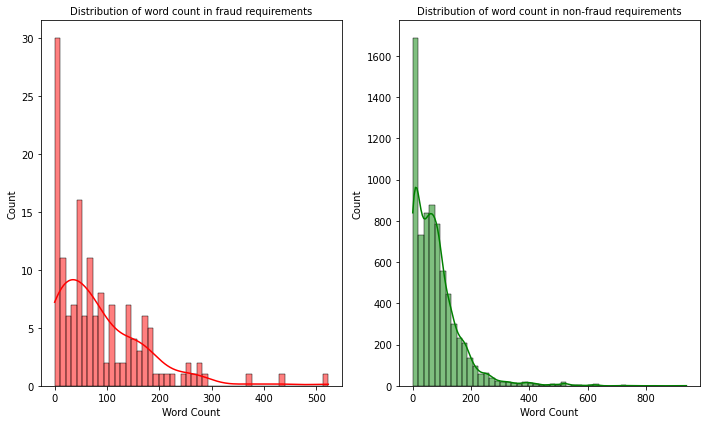

In [92]:
f, axes = plt.subplots(1, 2, figsize=(10, 6), sharex=False)
num_words_fraud = word_data[word_data["fraudulent"]==1]['num_words_requirements']
num_words_nonfraud = word_data[word_data["fraudulent"]==0]['num_words_requirements']
sns.histplot(num_words_fraud, 
             color='r', bins=50, kde=True, ax=axes[0])
sns.histplot(num_words_nonfraud, 
             color='g', bins=50, kde=True, ax=axes[1])

axes[0].set_title('Distribution of word count in fraud requirements', fontsize=10)
axes[1].set_title('Distribution of word count in non-fraud requirements', fontsize=10)
axes[0].set(xlabel="Word Count", ylabel = "Count")
axes[1].set(xlabel="Word Count", ylabel = "Count")
plt.tight_layout()
plt.show()

#### Benefits

In [93]:
word_data['num_words_benefits'] = word_data['benefits'].str.split().map(lambda x: len(x) if type(x) != float else 0)

##### Plotting

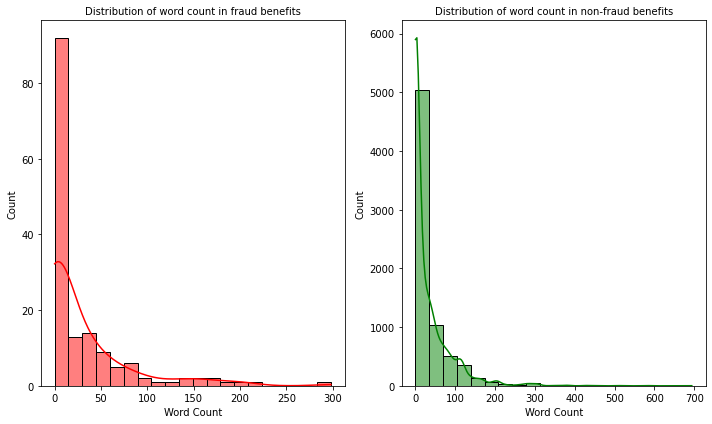

In [94]:
f, axes = plt.subplots(1, 2, figsize=(10, 6), sharex=False)
num_words_fraud = word_data[word_data["fraudulent"]==1]['num_words_benefits']
num_words_nonfraud = word_data[word_data["fraudulent"]==0]['num_words_benefits']
sns.histplot(num_words_fraud, 
             color='r', bins=20, kde=True, ax=axes[0])
sns.histplot(num_words_nonfraud, 
             color='g', bins=20, kde=True, ax=axes[1])

axes[0].set_title('Distribution of word count in fraud benefits', fontsize=10)
axes[1].set_title('Distribution of word count in non-fraud benefits', fontsize=10)
axes[0].set(xlabel="Word Count", ylabel = "Count")
axes[1].set(xlabel="Word Count", ylabel = "Count")
plt.tight_layout()
plt.show()

## Removing unneeded columns

In [95]:
X_train = X_train.drop(columns = ['job_id', 'company_profile', 'description', 'requirements', 'benefits'])
X_test = X_test.drop(columns = ['job_id', 'company_profile', 'description', 'requirements', 'benefits'])

## Word Embeddings

In [96]:
text_df = X_train.copy()
text_df = text_df.drop_duplicates(subset=['concat_text']).reset_index(drop=True)

In [97]:
lst_text = list(text_df['lst_tokens'])
model_embedding = Word2Vec(sentences=lst_text, size=100, window=6, min_count=3, workers=4, iter=20)

In [98]:
model_embedding.wv.most_similar("salary", topn=3)

[('wage', 0.7407636642456055),
 ('remuneration', 0.6762065291404724),
 ('compensation', 0.6734500527381897)]

In [99]:
model_embedding.wv.most_similar("technology", topn=3)

[('software', 0.4841199517250061),
 ('spatially', 0.45035457611083984),
 ('platform', 0.40747910737991333)]

In [100]:
from sklearn.manifold import TSNE

In [101]:
vocab = list(model_embedding.wv.vocab)
X = model_embedding.wv[vocab]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
tsne_df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [102]:
%matplotlib inline

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(tsne_df['x'], tsne_df['y'])
for word, pos in tsne_df.iterrows():
    ax.annotate(word, pos)

ax.set_xlim(-18, -10)
ax.set_ylim(-43, -40)

plt.show()

In [ ]:
words = set(model_embedding.wv.vocab)
X_train_vect = np.array([np.array([model_embedding.wv[i] for i in ls if i in words])
                         for ls in X_train['lst_tokens']], dtype=object)
X_test_vect = np.array([np.array([model_embedding.wv[i] for i in ls if i in words])
                         for ls in X_test['lst_tokens']], dtype=object)

In [ ]:
X_train_vect_avg = []
for vec in X_train_vect:
    if vec.size:
        X_train_vect_avg.append(vec.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))

X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))

In [ ]:
X_train = X_train.drop(['concat_text','lst_tokens'], axis=1)
X_test = X_test.drop(['concat_text','lst_tokens'], axis=1)

In [ ]:
X_test.to_csv('../datasets/word2vec/test_data_not_encoded.csv')
X_train.to_csv('../datasets/word2vec/train_data_not_encoded.csv')
# files.download('test_data_not_encoded.csv')
# files.download('train_data_not_encoded.csv')

## One Hot Encoding

#### Dropping Columns that do not need to be OHE

In [121]:
X_train_OHE = X_train.drop(['num_words_company_profile'], axis = 1)
X_test_OHE = X_test.drop(['num_words_company_profile'], axis = 1)

#### OHE

In [122]:
# standardise boolean to be True/ False
X_train_OHE['salary_indicated'] = X_train_OHE['salary_indicated'].apply(lambda x: x == 1)
X_test_OHE['salary_indicated'] = X_train_OHE['salary_indicated'].apply(lambda x: x == 1)
# add new row to account for values in test dataset unseen in train dataset
new_row = pd.Series({'location': 'Unseen', 'telecommuting': False, 'has_company_logo' : False, 'has_questions': False,
       'employment_type': 'Unseen', 'required_experience': 'Unseen', 'required_education': 'Unseen',
       'industry': 'Unseen', 'function': 'Unseen', 'salary_indicated': False})
X_train_OHE = pd.concat([X_train_OHE, new_row.to_frame().T], ignore_index=True)

In [123]:
# check number of unique values for each categorical feature in train set
X_train_uniq = pd.DataFrame(list(X_train_OHE.columns)).rename(columns={0:"attribute"})
X_train_uniq['uniq_val'] = [X_train_OHE[attribute].nunique() for attribute in X_train_OHE.columns]

TypeError: ignored

In [120]:
# check number of unique values for each categorical feature in test set
X_test_uniq = pd.DataFrame(list(X_test_OHE.columns)).rename(columns={0:"attribute"})
X_test_uniq['uniq_val'] = [X_test_OHE[attribute].nunique() for attribute in X_test_OHE.columns]

TypeError: ignored

In [119]:
# OHE for train set then remove artificially created row for unseen
X_train_transformed = pd.get_dummies(data=X_train_OHE, columns=X_train_OHE.columns, dummy_na=True)[:-1]
X_train_OHE = X_train_OHE[:-1]

TypeError: ignored

In [ ]:
# Helper function to one hot encode test set
def OHE_test(df, train_cols):
  # Empty df to concatenate transformed rows
  X_test_transformed = pd.DataFrame(columns=train_cols)

  for row in np.array(df):
    # start with all zeroes for each row
    transformed_row = np.zeros(len(train_cols),dtype=int)

    # mark relevant columns as 1
    for idx in range(df.shape[1]):

      col_val = row[idx]
      if not isinstance(col_val, str):
        col_val = str(col_val)

      transformed_col_name = df.columns[idx] + '_' + col_val
      transformed_col_unseen = df.columns[idx] + '_' + 'Unseen'

      if transformed_col_name in train_cols:
        transformed_row[list(train_cols).index(transformed_col_name)] = 1
      else:
        transformed_row[list(train_cols).index(transformed_col_unseen)] = 1

    #append to df
    X_test_transformed = pd.concat([X_test_transformed, pd.DataFrame(transformed_row, train_cols).T])

  return X_test_transformed

In [ ]:
X_test_transformed = OHE_test(X_test_OHE, X_train_transformed.columns)

#### Cleaning final df to be imputed

In [ ]:
X_test_transformed = X_test_transformed.reset_index(drop = True)

In [ ]:
## Drop nan columns and replace with nan values instead
def replace_nan_columns(df):
  columns_nan = [i for i in df if 'nan' in i.split('_')]

  for idx,row in df.iterrows():
    for nan_col in columns_nan:
      if row[nan_col]  == 1:
        col = nan_col.replace('_nan',"")
        
        for val_col in df.columns:
          if col in val_col:
            df.loc[idx,val_col] = np.nan
  return df


In [ ]:
X_train_final = replace_nan_columns(X_train_transformed)
X_test_final = replace_nan_columns(X_test_transformed)

## KNN Imputer

In [ ]:
## optimal k value: square root of n (119)
import math

k = int(math.sqrt(len(X_train_final)))

In [ ]:
from sklearn import preprocessing
from sklearn.impute import KNNImputer
import numpy as np

In [ ]:
imputer = KNNImputer(n_neighbors=1)
X_train_imputed = imputer.fit_transform(X_train_final)

In [108]:
X_train_imputed = pd.DataFrame(X_train_imputed, columns = X_train_final.columns)

NameError: ignored

In [ ]:
X_test_imputed = imputer.transform(X_test_final)
X_test_imputed = pd.DataFrame(X_test_imputed, columns = X_train_final.columns)

## Adding back variables excluded from imputation

In [109]:
X_train_imputed['num_words_company_profile'] = X_train['num_words_company_profile']

NameError: ignored

In [ ]:
X_test_imputed['num_words_company_profile'] = X_test['num_words_company_profile']

In [ ]:
X_train_imputed = X_train_imputed.join(pd.DataFrame(X_train_vect_avg))
X_test_imputed = X_test_imputed.join(pd.DataFrame(X_test_vect_avg))

In [ ]:
X_train_imputed.head()

,location_AE,location_AM,location_AR,location_AT,location_AU,location_BD,location_BE,location_BG,location_BH,location_BR,...,90,91,92,93,94,95,96,97,98,99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.295634,0.267702,-0.066177,-0.374377,-0.152100,-0.604407,0.171578,0.408361,0.083279,0.476059
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.162972,-0.051890,-0.303110,-0.060512,-0.049486,-0.195393,0.083833,0.377807,-0.132636,0.292937
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.330897,0.124838,-0.290956,-0.019430,0.115942,-0.655665,-0.137564,0.184403,0.213490,0.322497
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.657245,0.544620,-0.138936,-0.135227,0.052873,-0.093108,0.211060,0.437528,0.366243,0.236672
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.216221,-0.841159,-0.282773,0.704828,-0.306116,-0.608831,-0.137544,-0.281381,0.137334,0.544368


## Removing columns with column name that includes nan

In [ ]:
X_train_imputed_final = X_train_imputed[X_train_imputed.columns.drop(list(X_train_imputed.filter(regex='nan')))]
X_test_imputed_final = X_test_imputed[X_test_imputed.columns.drop(list(X_test_imputed.filter(regex='nan')))]

In [ ]:
X_train_imputed_final

,location_AE,location_AM,location_AR,location_AT,location_AU,location_BD,location_BE,location_BG,location_BH,location_BR,...,90,91,92,93,94,95,96,97,98,99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.295634,0.267702,-0.066177,-0.374377,-0.152100,-0.604407,0.171578,0.408361,0.083279,0.476059
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.162972,-0.051890,-0.303110,-0.060512,-0.049486,-0.195393,0.083833,0.377807,-0.132636,0.292937
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.330897,0.124838,-0.290956,-0.019430,0.115942,-0.655665,-0.137564,0.184403,0.213490,0.322497
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.657245,0.544620,-0.138936,-0.135227,0.052873,-0.093108,0.211060,0.437528,0.366243,0.236672
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.216221,-0.841159,-0.282773,0.704828,-0.306116,-0.608831,-0.137544,-0.281381,0.137334,0.544368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.899163,0.218402,-0.653225,-0.365121,0.167596,-0.360935,0.025725,0.426255,-0.176720,0.466336
11512,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.076761,-0.030365,-0.394424,-0.379180,0.194127,-0.109165,0.232528,0.427620,0.065899,0.156622
11513,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.049550,-0.189791,-0.310533,0.378269,-0.330355,-0.386204,-0.098078,0.132305,-0.169782,0.223993
11514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.070820,0.099260,-0.089032,-0.057006,0.069731,-0.527464,-0.341648,0.553733,-0.012441,0.477397


In [ ]:
X_train_imputed_final.shape

(11516, 263)

In [ ]:
X_test_imputed_final.shape

(2880, 263)

In [ ]:
y_train.shape

(11516,)

In [ ]:
y_test.shape

(2880,)

In [ ]:
set(X_train_imputed['function_Supply Chain'])

{0.0, 1.0}

## Save to Csv

In [ ]:
X_train_imputed_final.to_csv('../datasets/word2vec/train_data_imputed_FINAL.csv', index=False)
# files.download('train_data_imputed_FINAL.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
X_test_imputed_final.to_csv('../datasets/word2vec/test_data_imputed_FINAL.csv', index=False)
# files.download('test_data_imputed_FINAL.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_test.to_csv('../datasets/word2vec/y_test_FINAL.csv')
# files.download('y_test_FINAL.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_train.to_csv('../datasets/word2vec/y_train_FINAL.csv')
# files.download('y_train_FINAL.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>